In [10]:
import cantera as ct
import numpy as np
import csv

# %config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
import matplotlib.pylab as plt

print('running cantera version: ' + ct.__version__)

running cantera version: 3.0.0


In [11]:
gas = ct.Solution("data/ss_mech.yaml")

C:\Users\tahze\AppData\Local\Temp\ipykernel_31504\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in cp/R detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  4.1640474673509615
	Value computed using high-temperature polynomial: 2.7303344722452962

  gas = ct.Solution("data/ss_mech.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_31504\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in h/RT detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  -1677.869344773688
	Value computed using high-temperature polynomial: -1656.701813502562

  gas = ct.Solution("data/ss_mech.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_31504\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in s/R detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  11.253302479772398
	Value computed using high-temperature polynomial: 14.675098919376222

In [12]:
reactor_T = 2050.0 # temp of AP premixed flame
reactor_P = 101325 # Pa

mass_percent_AP = 85

n_NH3 = mass_percent_AP/117.49  # deflagration of AP (not gas phase)
n_HCLO4 = n_NH3
n_C2H4 = (100-mass_percent_AP)/28.00 # almost all HTPB decomposes into C2H4 at high temp of reactor

phi = (2/0.523)/((2*n_NH3)/n_C2H4)


density_AP = 1.95 # g/cc
density_HTPB = 0.92 # g/cc
rho = 0.01*(mass_percent_AP*density_AP + (100-mass_percent_AP)*density_HTPB)

gas.set_equivalence_ratio(phi=phi, fuel="C2H4", oxidizer={"NH3": 1.0, "HCLO4": 1.0})

gas.TP = reactor_T, reactor_P

In [13]:
gas()


  gas:

       temperature   2050 K
          pressure   1.0132e+05 Pa
           density   0.31438 kg/m^3
  mean mol. weight   52.883 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        2.0792e+06        1.0996e+08  J
   internal energy        1.7569e+06        9.2912e+07  J
           entropy            6510.7        3.4431e+05  J/K
    Gibbs function       -1.1268e+07       -5.9588e+08  J
 heat capacity c_p            1436.9             75990  J/K
 heat capacity c_v            1279.7             67675  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
              C2H4           0.10128           0.19092           -34.299
               NH3           0.13028           0.40454            -32.86
             HCLO4           0.76844           0.40454           -37.372


In [14]:
initial_pressure = 1  # MPa
final_pressure = 10.0  # MPa
pressure_step = 0.01  # MPa

In [15]:
def calculate_burn_rate(gas, pressure, temp, max_time=0.1):
    reactor = ct.IdealGasReactor(gas)
    gas.TP = temp, pressure * 1.0e6  # Convert pressure to Pa

    sim = ct.ReactorNet([reactor])

    rho = reactor.density

    # Track the progress of the reaction and time
    progress = []
    time = []

    while sim.time < max_time:
        sim.step()
        time.append(sim.time)
        progress.append((reactor.Y[gas.species_index('NH3')] + reactor.Y[gas.species_index('C2H4')] + reactor.Y[gas.species_index('HCLO4')])*reactor.mass*1000)

    # Calculate the burn rate (cm/s) based on progress and time
    # Use central difference method to calculate derivative
    delta_time = np.diff(time)
    delta_progress = np.diff(progress)
    burn_rate = abs(delta_progress) / abs(delta_time) # g/s

    burn_rate /= reactor.density # cm3/s
    # considering a 1cm by 1cm square area, we can say this is the burn rate in cm/s

    return time, max(burn_rate)  # Return the initial burn rate

In [16]:
pressures = np.arange(initial_pressure, final_pressure, pressure_step)
burn_rates = []

for pressure in pressures:
    _, burn_rate = calculate_burn_rate(gas, pressure, reactor_T)
    burn_rates.append(burn_rate)

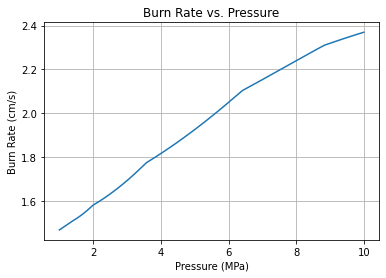

In [17]:
# Plot the burn rate vs. pressure
plt.plot(pressures, burn_rates)
plt.xlabel('Pressure (MPa)')
plt.ylabel('Burn Rate (cm/s)')
plt.title('Burn Rate vs. Pressure')
plt.grid()
plt.show()

In [18]:
gas()


  gas:

       temperature   2545.9 K
          pressure   1.5251e+05 Pa
           density   0.31438 kg/m^3
  mean mol. weight   43.635 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy         2.242e+06         9.783e+07  J
   internal energy        1.7569e+06        7.6663e+07  J
           entropy            7801.6        3.4042e+05  J/K
    Gibbs function        -1.762e+07       -7.6884e+08  J
 heat capacity c_p            1584.1             69121  J/K
 heat capacity c_v            1393.5             60806  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               H2O          0.054915           0.13301           -41.617
                 O        7.2793e-15        1.9853e-14           -41.955
                O2          0.061113          0.083338           -31.72